---
title: "Tackling Tabular Problems III: Feature Engineering & Selection"
date: "2022-11-10"
image: "image.png"
format:
  html:
    code-fold: true
    code-line-numbers: false
jupyter: python3
---

## Feature Engineering

In tabular problems, feature engineering can have a huge impact, potentially separating mediocre models from fantastic models. In essence, engineering features can serve three purposes:
- Increase the predictive performance and generalization of a model
- Increase the interpretability of a model
- Reduce the complexity of a model (memory footprint, computational requirements)

How can we come up with a great set of features? Successful feature engineering begins with a thorough understanding of the business problem that we want to solve (e.g., if the data concerns human decisions, imagine the decision process and think about each step and how they interact; what would have influenced you in your decision?) and the data we have (we already covered this in the section about EDA; what can the features tell us about the target?). Then we should ask how we can transform our data in representations that can be better exploited by our model. This is a highly creative endeavor and should be treated as such. Which features would help you if you had to make a prediction? Which features could help the model detect patterns in the data? Hold brainstorming sessions and try to get inspirations from solutions that worked well in similar problems. Also, error analysis really is very important. Sorting the observations by error and plotting the residuals for different groups in the data are common strategies for revealing relevant patterns that can lead to new ideas and directions for feature engineering.

In general, the best features will be problem-specific and therefore hard to systematize. Nonetheless, we can look at some general feature engineering techniques that can help in many problems. Depending on the problem domain (e.g., biology, finance) there may be many other common techniques.

### Column-based features

#### Numerical features

- **Treating missing values**:
    - Fill in the correct value: In some cases, we may know the correct value. For instance, if `NaN` sales simply means an absence of any transactions, we can replace missing values with `0`s. Note that there are cases where `NaN` actually is the correct value (e.g., the age of the spouse for singles).
    - Keep the missing values: Assuming that we use a model that can handle `NaN`s natively (like XGBoost and its relatives), this is generally the best approach. Keeping missing values allows the model to capture information that is contained in the missingness (e.g., in a dataset for tax fraud detection, missingness may not occur at random but rather tell us a lot about the target). Alternatively, try replacing `NaN`s with a value that is far from the other values (e.g., `-999`; depending on the implementation, this can result in slightly different splits).
    - Add a binary column: It can help to add a binary column that indicates whether a value is/was missing.
    - Imputation: Since we want to preserve the data properties and don't want to break our model (linear models can be quite sensitive in this regard), good imputation is very challenging. While there are many possible techniques (just see the scikit-learn [user guide](https://scikit-learn.org/stable/modules/impute.html)), it is quite common to fill in the mean or median. (Needless to say, the imputation value should only be derived from the training data.) However, filling in a constant value can often cause problems (e.g., when there are groups in the data). If domain knowledge doesn't come to the rescue, it is best to just use a model that handles missingness natively.
- **Treating outliers**: Outliers are usually detrimental to the performance of a model. Thus, it is important to identify and treat them if necessary.
    - Identify outliers: There is no general method to identify outliers. If domain knowledge doesn't help, common techniques are based on the standard deviation (e.g., values that fall outside of 3 standard deviations from the mean) or interquartile range (e.g., values that fall outside of `1.5 * IQR`). For more sophisticated approaches see the scikit-learn [guide](https://scikit-learn.org/stable/modules/outlier_detection.html).
    - Treat outliers: The best treatment of outliers ultimately depends on the problem. While we may want to keep outliers in some settings (e.g., in anomaly detection), we'll want to cap, modify or remove them in others. It can also be useful to add a binary column indicating known outliers.


- **Binning**: There are three typical motives for binning: reducing the memory footprint of a feature, removing noise and errors, and making it easier to model non-linear relationships between a feature and the target. Common methods for binning are `pandas`' `cut` and scikit-learn's [`KBinsDiscretizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html). Binning can be combined with/used for frequency encoding.
- **Rounding**: This is another form of lossy compression. Can be useful when high degrees of precision translate to noise.
- **Splitting**: Split a value into its integer and decimal part. Can be useful in certain use cases (e.g., prices).
- **Ranking**: Rank the observations by a feature column (e.g., using the `rank()` method in `pandas`) and use the ranks as a feature.
- **Transforming**: Transforming numerical variables can be useful to increase the performance and/or the interpretability of a model. (Note: Tree-based models generally don't benefit from feature scaling. However, it can sometimes help to transform the target in order to better optimize for some objective function.)
    - Logarithmic transformation: Taking the (natural) logarithm is often seen in practice and can have multiple benefits.
        - The log transformation can reduce skewness and improve the fit of the model. In practice, the log transform is often used as a default preprocessing technique when a variable is heavy-tailed.
        - The log transformation can increase the interpretability of a coefficient.
        - A linear model on the logarithmic scale corresponds to a multiplicative model on the original scale.
        - Log transforming outcomes that are all positive forces the predictions to be positive.
    - Square root transformation: Taking the square root of a variable is an alternative to the logarithmic transformation that compresses high values more mildly. It doesn't come with the interpretability benefits of the log transform, however.
    - Standardization:
        - using $z$-scores: Subtract the mean and divide by the standard deviation. This is the default preprocessing approach for neural networks (which generally require and are quite sensitive to feature scaling). Implemented in `scikit-learn`'s [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).
        - using a reasonable scale: To increase interpretability, it can sometimes help to rescale variables (e.g., divide income by 10,000).
    - Normalization: Subtract the minimum value and divide by the range. Implemented in scikit-learn's [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html); an alternative to standardization for neural networks.
    - Centering: Centering a variable (by subtracting the mean or another reference value) can improve interpretability.
    - Other: Other common scalers are scikit-learn's [`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler) which is less sensitive to outliers, as well as [`PowerTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer) and [`QuantileTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) (which is probably a good choice when preprocessing tabular data for neural networks) which can be used to make data more Gaussian-like. See [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) for a comparison of different scaling methods.
    - Idiosyncratic transformations: Depending on the problem, there may be custom transformations that are useful.
    
    
- **Dimensionality reduction**: Run PCA/t-SNE/UMAP on the data and use the outputs as features.
- **Polynomial features**: Raise features to an exponent.
- **Aggregations/Group statistics**: If there are groups in the data (e.g., age groups, areas, dates, departments, clusters derived by cluster analysis), compute features for each group (e.g., mean, median, standard deviation, minimum, maximum, sum, skewness, kurtosis, etc.). This can help the model pick up differences between groups. Try combining multiple groups before computing group statistics.
- **Interactions**: Add, subtract, multiply or divide two features. These features are often very important (while two features may not correlate with the target on their own, their interaction may very well provide signal).

#### Categorical features

- **Treating missing values**:
    - Fill in the correct value: Determine the correct value using domain knowledge.
    - Keep the missing values: Use a model that can handle missing values natively. Again, this is probably the best approach.
    - Create a new category: Create a new category that represents missing values. Instead of `NaN` we can use a value that is markedly different from the other values (e.g., a large negative value like `-999`).
    - Fill in the mode (or another category): Like with numerical variables, this is usually not the best idea. Use a model that can handle missing values instead. 
- **Splitting into multiple categories**: Depending on the dataset, there may be features that can be derived from splitting a categorical variable. Below are some common ones.
    - Dates/Timestamps: Many features can be derived directly from dates and timestamps (e.g., year, month, day, week of year, quarter, etc.).
    - Addresses: Addresses can be split into state, city, district, etc.
    - User agent: Many features can be derived from user agent strings (used in HTTP): `is_mobile`, `is_latest_version`, `operating_system`, etc.
- **Combining multiple categories in one**: Sometimes merging two categorical features into one can help the model (e.g., slightly different job descriptions, very rare categories).
- **Encoding**:
    - Label encoding: Convert each category to a unique integer label (e.g., using scikit-learn's [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) or `pandas`' `factorize()` method). This is the default approach for tree-based models and usually works surprisingly well. An option for neural networks.
    - One-hot encoding: Create a binary column for each category (e.g., using scikit-learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). This is the default approach for linear models (where one category is usually used as a baseline). An option for neural networks.
    - Frequency encoding: Replace each category with its frequency in the training data (e.g., by using `pandas`' `value_counts()` as a dictionary). Alternatively, try converting to ranks.
    - Target encoding: Replace each category with the corresponding target probability (in classification) or average (in regression). Can be the best encoding technique, but comes with a higher risk of overfitting (it can help to add some noise to combat this). See [here](https://contrib.scikit-learn.org/category_encoders/targetencoder.html) for an implementation.
    - Embeddings: Create vector embeddings that represent categorical data. Primarily useful for neural networks.

#### Features created by a model

Quite often we find that there is a feature that would provide a lot of signal to the model but isn't available in the dataset. In situations like this, it may be possible to create a model that leverages the existing data and can predict the feature in question accurately enough. An example: Imagine that we want to create a model that predicts the number of clicks generated by ads for used cars. Common sense tells us that the number of clicks will depend on how the price offered in the ad compares to the typical market price of the product. Maybe we can create a model that predicts the price of the car and use the price difference as a feature?

### Row-based features

While column-based features are probably more intuitive, it can also be beneficial to compute row-wise features to help the model find patterns in the data. Some examples are:
- Compute the mean, median, standard deviation, minimum, maximum, sum, etc. of the numeric values (or a reasonable subset).
- Compute an average score of how much the column values deviate from their mean or median.
- Count missing values, 0s, positive/negative values, etc.
- Clustering: Cluster the data (e.g., using an unsupervised algorithm like [K-Means](https://docs.rapids.ai/api/cuml/stable/api.html#k-means-clustering)) and add the cluster labels as a feature.

## Feature selection

Even though we hope that every newly created feature provides important information to the model, this is usually not the case. Instead we'll often end up with many features that are not really relevant for the problem or even just introduce noise. Thus, feature selection (i.e., reducing the size of the feature set) may be necessary for several reasons:
- **Increase predictive performance**: The impact of uninformative features on a model's predictions generally depends on the model type. While neural networks are typically very sensitive to irrelevant features, tree-based models should be able to simply ignore them. In practice though, their performance usually suffers at least to some degree too. Thus, dropping features is often a way to get better predictions.
- **Easier data collection**: Depending on the problem setting, good features that can be easily collected can be better than great features that are expensive to acquire. This may actually be quite important in practice.
- **Reduce computation/memory requirements**: Reduce the size of the feature set in order to consume less memory and/or speed up training and inference.
- **Increase interpretability**: There is a trade-off between predictive performance and model interpretability. If interpretability matters it may be our goal to find a set of interpretable features with reasonable predictive performance.

So how should we select our features? In theory, the best approach to feature selection is simple: just try out all combinations and pick the feature set that fits the requirements best. In practice, this is of course computationally infeasible. Thus, many feature selection methods have been proposed. They generally fall into three main classes:
- **Intrinsic/Embedded methods**: Intrinsic feature selection happens implicitly when the model is fitted. Thus, they don't require any additional tools and build on a direct link between the objective function and feature selection. A common example are regularization models like lasso regression that force some predictors to be excluded from the model. Implicit feature selection also happens in tree-based models where predictors that are not used in any split are excluded from the model.
- **Filter methods**: Filter methods select features based on their properties (i.e., they don't involve a model). For instance, common criteria are based on correlation with the target, [mutual information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression) or [variance thresholds](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold). The advantage of filter methods is that they are simple, fast and easily understandable.
- **Wrapper methods**: Wrapper methods iteratively fit a model to a feature subset and use the resulting model performance to select the subset for the next iteration. They have the best chance of finding the most predictive features, but are  computationally demanding (and in some cases simply infeasible). Common wrapper methods are:
    - [Recursive feature elimination](https://scikit-learn.org/stable/modules/feature_selection.html#rfe) (RFE): Create an initial model using all available features. Eliminate the least important features (e.g., features with the smallest coefficients when using a linear model). Fit the model on the reduced set of features. Repeat until the desired number of features has been reached.
    - [Sequential feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#sequential-feature-selection) (SFS): 
        - Sequential forward selection: Begin with zero features. Fit a model for each available feature. Keep the feature that resulted in the best model performance. Repeat until the desired number of features has been reached.
        - Sequential backward selection: Begin with all $n$ available features. Fit a model to all subsets of size $n-1$. Keep the feature that is associated with highest drop in performance. Repeat until the desired number of features has been reached.
    - [Genetic algorithms]((http://www.feat.engineering/genetic-algorithms.html)): Genetic algorithms can be used effectively for feature selection.
    - [Permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html): Fit a model to all features. Then, for each feature, shuffle the feature column and score the predictions of the model. The higher the drop in performance, the more important is the feature. Rank the features by their permutation importance and select the desired number of features.
    - [SHAP](https://github.com/slundberg/shap): SHAP is a model-agnostic method for explaining individual predictions that has its roots in Shapley values from cooperative game theory. (See [here](https://h2o.ai/blog/shapley-values-a-gentle-introduction/) and [here](https://christophm.github.io/interpretable-ml-book/shap.html) for more on SHAP.) A great method for interpretable ML, it can be used effectively for computing feature importances (and thus feature selection) as well. For each feature we simply average the absolute values across the data to obtain [global feature importances](https://christophm.github.io/interpretable-ml-book/shap.html#shap-feature-importance) or we analyze a [summary plot](https://christophm.github.io/interpretable-ml-book/shap.html#shap-summary-plot) that visualizes the feature importances and effects for all instances. Note that SHAP values can be computed using GPU acceleration from inside XGBoost (just set `pred_contribs=True` when using `model.predict()`) which provides massive speed-ups. It is therefore easy to compute SHAP values as a default in a modeling pipeline. (Of course, we shouldn't trust feature importance scores blindly because they can reflect bias in the data. In this case, it can be necessary to remove "important" features!)


Which of these methods is best suited for a given problem depends on many factors (number of features, resource constraints, etc.). However, note that the methods outlined above generally imply that feature selection is a separate step that comes after feature engineering. In practice, this may not be ideal. At least in situations when we don't want to create large numbers of features automatically, we can proceed with feature engineering and feature selection in parallel. That is, we immediately try a newly created feature and keep it if the model improves in cross-validation. (In order to know whether the improvement is large enough, we should check the variation of the validation score between folds and/or seeds. The improvement should exceed this variation. Also, keep an eye on the train and the CV score. Adding a new feature shouldn't widen the gap between both scores significantly; otherwise we are probably overfitting.) This approach can make feature engineering more natural (even more so if combined with analyzing SHAP values), allowing us to find suitable directions for improvement and understand the problem more thoroughly.

## Example: Rocket League

Let's turn our attention to the Rocket League example. Instead of creating a large number of features and applying feature selection afterwards, we'll stick to the iterative approach and try to engineer useful features based on an intuitive understanding of the data. In order to make the most out of GPU acceleration, we'll use `cudf` and `cupy` for feature engineering, and `xgboost` for modeling and the computation of Shap values.

In [13]:
import pandas as pd
import cudf
import cupy
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss
from pathlib import Path
import re
import gc

In [2]:
data_path = Path("/kaggle/input/rocket-league")

In [6]:
train_df = pd.read_feather(data_path/"train.feather")
test_df = pd.read_feather(data_path/"test.feather")

train_df = cudf.from_pandas(train_df)
test_df = cudf.from_pandas(test_df)

In [20]:
target = "team_A_scoring_within_10sec"
original_features = [col for col in train_df if col not in ["game_num", "event_id", target]]

In [14]:
xgb_params = { 
    "learning_rate": 0.01,
    "eval_metric":"logloss",
    "objective":"binary:logistic",
    "tree_method":"gpu_hist",
    "predictor":"gpu_predictor",
    "random_state":1,
}

In [15]:
def run_cv(df, features, compute_shap=True):
    cv = GroupKFold(n_splits=5)
    oof = np.zeros(df.shape[0])
    scores = []
    
    for fold, (train_idx, valid_idx) in enumerate(cv.split(df, groups=df.game_num.to_numpy())):        
        dtrain = xgb.DMatrix(data=df.iloc[train_idx][features], label=df.iloc[train_idx][target])
        dvalid = xgb.DMatrix(data=df.iloc[valid_idx][features], label=df.iloc[valid_idx][target])
        
        model = xgb.train(xgb_params,
                          dtrain=dtrain,
                          evals=[(dtrain, "train"), (dvalid, "valid")],
                          num_boost_round=1000,
                          verbose_eval=1000)
        
        if compute_shap and fold == 0:
            shap_values = model.predict(dvalid, pred_contribs=True)
        
        oof_preds = model.predict(dvalid)
        oof[valid_idx] = oof_preds
        
        score = log_loss(df.iloc[valid_idx][target].to_numpy(), oof_preds)
        print(f"Fold {fold} score: {score:.5f}")
        scores.append(score)

        del dtrain, dvalid, model, oof_preds, score
        gc.collect()
    
    print(f"CV score: {np.mean(scores):.5f}")
    
    return shap_values

Let's begin by creating a baseline XGBoost model using all original features.

In [17]:
shap_values = run_cv(train_df, original_features)

[0]	train-logloss:0.68522	valid-logloss:0.68526
[999]	train-logloss:0.18825	valid-logloss:0.19905
Fold 0 score: 0.19905
[0]	train-logloss:0.68523	valid-logloss:0.68524
[999]	train-logloss:0.18886	valid-logloss:0.19658
Fold 1 score: 0.19658
[0]	train-logloss:0.68524	valid-logloss:0.68522
[999]	train-logloss:0.18973	valid-logloss:0.19331
Fold 2 score: 0.19331
[0]	train-logloss:0.68524	valid-logloss:0.68522
[999]	train-logloss:0.18995	valid-logloss:0.19237
Fold 3 score: 0.19237
[0]	train-logloss:0.68524	valid-logloss:0.68523
[999]	train-logloss:0.18977	valid-logloss:0.19301
Fold 4 score: 0.19301
CV score: 0.19486


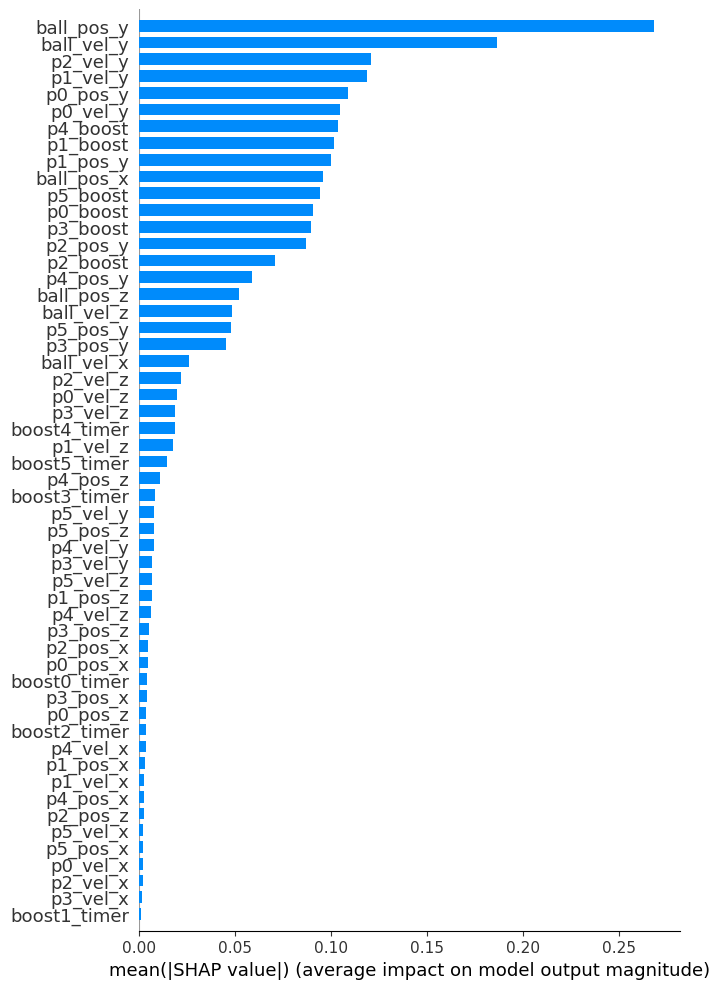

In [21]:
shap.summary_plot(shap_values[:, :-1], original_features, plot_type="bar", max_display=70, plot_size=(7, 10))

Looking at the Shap values we notice two things:
- The position of the ball, the direction of movement of the ball and the players, and the boost that is available to the players are the most important features. This makes intuitive sense.
- At least without further feature engineering, the `x` and `z` position of the players, the players' `x` velocity, and the boost timer features are not really useful for the model.

Let's see how the model performs when we drop the least important features.

In [23]:
original_features = [f for f in original_features if f not in list(filter(re.compile("p[0-5]_pos_x").match, original_features))]
original_features = [f for f in original_features if f not in list(filter(re.compile("p[0-5]_pos_z").match, original_features))]
original_features = [f for f in original_features if f not in list(filter(re.compile("p[0-5]_vel_x").match, original_features))]
original_features = [f for f in original_features if "timer" not in f]

In [24]:
shap_values = run_cv(train_df, original_features)

[0]	train-logloss:0.68522	valid-logloss:0.68526
[999]	train-logloss:0.18868	valid-logloss:0.19893
Fold 0 score: 0.19893
[0]	train-logloss:0.68523	valid-logloss:0.68524
[999]	train-logloss:0.18938	valid-logloss:0.19656
Fold 1 score: 0.19656
[0]	train-logloss:0.68524	valid-logloss:0.68522
[999]	train-logloss:0.19023	valid-logloss:0.19323
Fold 2 score: 0.19323
[0]	train-logloss:0.68524	valid-logloss:0.68522
[999]	train-logloss:0.19036	valid-logloss:0.19230
Fold 3 score: 0.19230
[0]	train-logloss:0.68524	valid-logloss:0.68523
[999]	train-logloss:0.19029	valid-logloss:0.19292
Fold 4 score: 0.19292
CV score: 0.19479


As expected, the CV score doesn't deteriorate (it actually improves slightly). 

Let's move on and engineer some new features. Judging from the Shap values and our understanding of the dataset, the `y` position of the ball is a very important feature. So let's build on this and compute the Euclidean distance of the ball to the goal of team B as well as the relative distance:

In [25]:
def euclidean_dist(a, b):
    return cupy.linalg.norm(a - b, axis=1)

def distance_ball_goal(df):
    ball_pos = df[[f"ball_pos_{c}" for c in ["x", "y", "z"]]]
    df["dist_ball2goalA"] = euclidean_dist(ball_pos.values, cupy.array([0, 100, 6])).astype("float32")
    df["dist_ball2goalB"] = euclidean_dist(ball_pos.values, cupy.array([0, -100, 6])).astype("float32")
    df["dist_ball2goal_A_rel_B"] = (df["dist_ball2goalA"] / df["dist_ball2goalB"]).astype("float32")
    return df

def compute_features(df):
    df = distance_ball_goal(df)
    return df

In [26]:
train_df = compute_features(train_df)
test_df = compute_features(test_df)

dist_ball_goal_features = ["dist_ball2goalB", "dist_ball2goal_A_rel_B"]
features = original_features + dist_ball_goal_features

In [27]:
shap_values = run_cv(train_df, features)

[0]	train-logloss:0.68520	valid-logloss:0.68524
[999]	train-logloss:0.18855	valid-logloss:0.19880
Fold 0 score: 0.19880
[0]	train-logloss:0.68521	valid-logloss:0.68522
[999]	train-logloss:0.18927	valid-logloss:0.19633
Fold 1 score: 0.19633
[0]	train-logloss:0.68522	valid-logloss:0.68520
[999]	train-logloss:0.19008	valid-logloss:0.19306
Fold 2 score: 0.19306
[0]	train-logloss:0.68522	valid-logloss:0.68520
[999]	train-logloss:0.19019	valid-logloss:0.19197
Fold 3 score: 0.19197
[0]	train-logloss:0.68522	valid-logloss:0.68521
[999]	train-logloss:0.19006	valid-logloss:0.19265
Fold 4 score: 0.19265
CV score: 0.19456


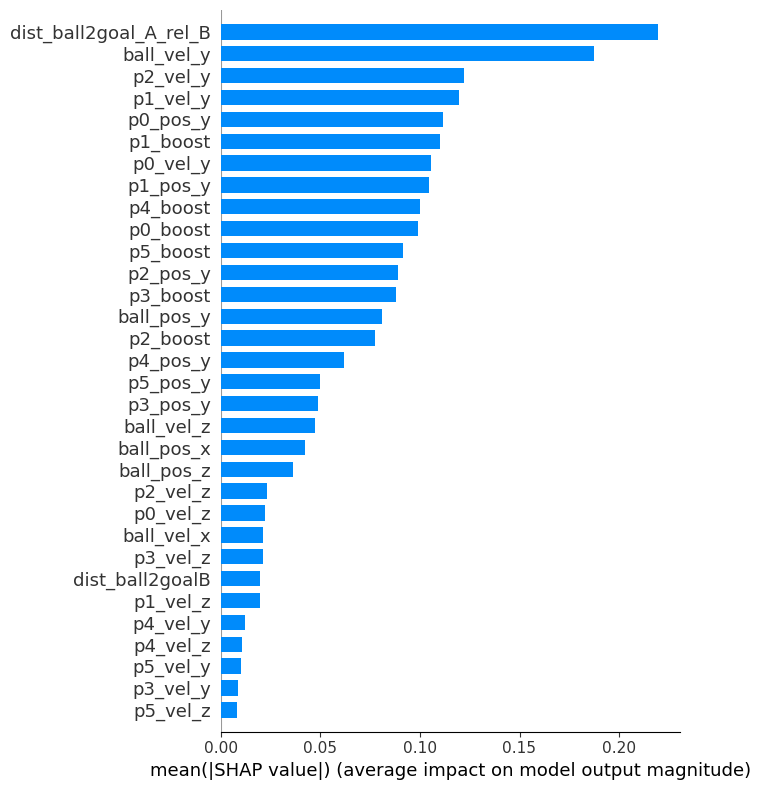

In [28]:
shap.summary_plot(shap_values[:, :-1], features, plot_type="bar", max_display=70, plot_size=(7, 8))

The CV score has improved (a little bit) and the relative distance is now the most important feature. Apparently, distance features can be quite useful for this dataset. What next? Intuitively, the distance of the players to the ball indicates which team is in possession. Let's compute the minimum and mean distance for both teams as well as the corresponding relative features:

In [35]:
def distance_team_ball(df):
    ball_pos = df[[f"ball_pos_{c}" for c in ["x", "y", "z"]]]
    
    for p in range(6):
        player_pos = df[[f"p{p}_pos_{c}" for c in ["x", "y", "z"]]]
        player_pos.fillna(-10000, inplace=True)
        df[f"dist_p{p}_2ball"] = euclidean_dist(player_pos.values, ball_pos.values).astype("float32")
        df[f"dist_p{p}_2ball"].loc[df[f"dist_p{p}_2ball"] > 300] = np.nan
        del player_pos
        gc.collect()
    
    df["dist_team2ball_A_min"] = df[[f"dist_p{p}_2ball" for p in range(3)]].min(axis=1)
    df["dist_team2ball_B_min"] = df[[f"dist_p{p}_2ball" for p in range(3, 6)]].min(axis=1)
    df["dist_team2ball_A_mean"] = df[[f"dist_p{p}_2ball" for p in range(3)]].mean(axis=1)
    df["dist_team2ball_B_mean"] = df[[f"dist_p{p}_2ball" for p in range(3, 6)]].mean(axis=1)
    df["dist_team2ball_min_A_rel_B"] = df["dist_team2ball_A_min"] / df["dist_team2ball_B_min"]
    df["dist_team2ball_mean_A_rel_B"] = df["dist_team2ball_A_mean"] / df["dist_team2ball_B_mean"]
    
    return df

def compute_features(df):
    df = distance_ball_goal(df)
    df = distance_team_ball(df)
    return df

In [41]:
train_df = compute_features(train_df)
test_df = compute_features(test_df)

dist_team_ball_features = ["dist_team2ball_A_min", "dist_team2ball_A_mean", "dist_team2ball_min_A_rel_B", "dist_team2ball_mean_A_rel_B"]
features += dist_team_ball_features

The as_gpu_matrix method will be removed in a future cuDF release. Consider using `to_cupy` instead.


In [42]:
shap_values = run_cv(train_df, features)

[0]	train-logloss:0.68519	valid-logloss:0.68523
[999]	train-logloss:0.18780	valid-logloss:0.19810
Fold 0 score: 0.19810
[0]	train-logloss:0.68520	valid-logloss:0.68521
[999]	train-logloss:0.18856	valid-logloss:0.19529
Fold 1 score: 0.19529
[0]	train-logloss:0.68521	valid-logloss:0.68520
[999]	train-logloss:0.18940	valid-logloss:0.19226
Fold 2 score: 0.19226
[0]	train-logloss:0.68521	valid-logloss:0.68520
[999]	train-logloss:0.18953	valid-logloss:0.19123
Fold 3 score: 0.19123
[0]	train-logloss:0.68521	valid-logloss:0.68521
[999]	train-logloss:0.18940	valid-logloss:0.19202
Fold 4 score: 0.19202
CV score: 0.19378


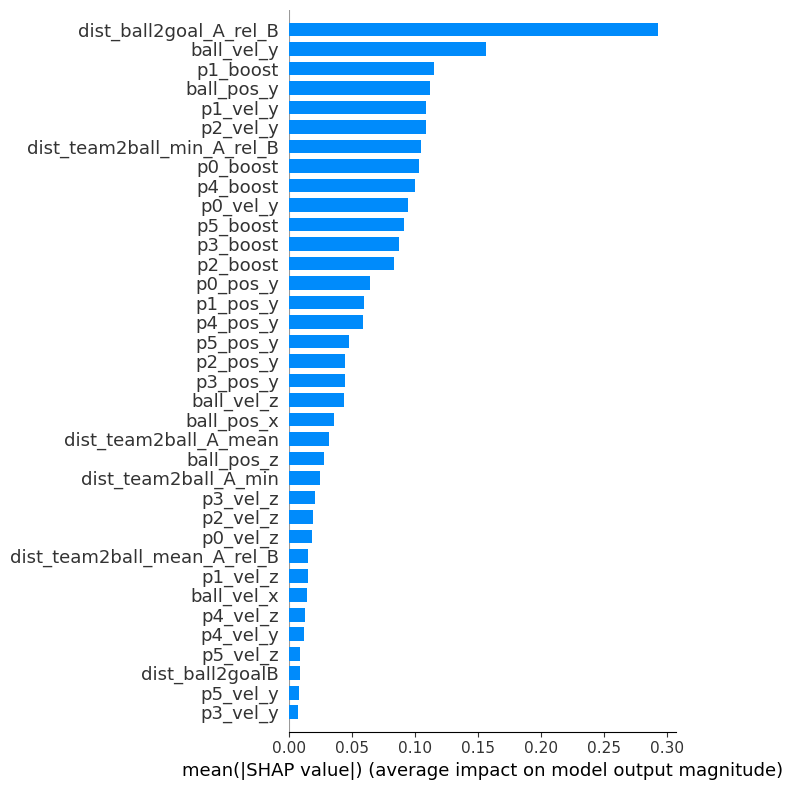

In [43]:
shap.summary_plot(shap_values[:, :-1], features, plot_type="bar", max_display=70, plot_size=(7, 8))

Adding these features leads to a quite significant improvement of the CV score. Thus, it may be a good idea to add features that capture the distance of the teams to the goals as well.

In [47]:
def distance_team_goal(df):
    for p in range(6):
        player_pos = df[[f"p{p}_pos_{c}" for c in ["x", "y", "z"]]]
        player_pos.fillna(-10000, inplace=True)
        df[f"dist_p{p}_2goalA"] = euclidean_dist(player_pos.values, cupy.array([0, 100, 6]))
        df[f"dist_p{p}_2goalB"] = euclidean_dist(player_pos.values, cupy.array([0, -100, 6]))
        df[f"dist_p{p}_2goalA"].loc[df[f"dist_p{p}_2goalA"] > 300] = np.nan
        df[f"dist_p{p}_2goalB"].loc[df[f"dist_p{p}_2goalB"] > 300] = np.nan
        del player_pos
        gc.collect()
    
    df["dist_team2goalA_A_min"] = df[[f"dist_p{p}_2goalA" for p in range(3)]].min(axis=1)
    df["dist_team2goalA_B_min"] = df[[f"dist_p{p}_2goalA" for p in range(3, 6)]].min(axis=1)
    df["dist_team2goalB_A_min"] = df[[f"dist_p{p}_2goalB" for p in range(3)]].min(axis=1)
    df["dist_team2goalB_B_min"] = df[[f"dist_p{p}_2goalB" for p in range(3, 6)]].min(axis=1)
    df["dist_team2goalA_A_mean"] = df[[f"dist_p{p}_2goalA" for p in range(3)]].mean(axis=1)
    df["dist_team2goalA_B_mean"] = df[[f"dist_p{p}_2goalA" for p in range(3, 6)]].mean(axis=1)
    df["dist_team2goalB_A_mean"] = df[[f"dist_p{p}_2goalB" for p in range(3)]].mean(axis=1)
    df["dist_team2goalB_B_mean"] = df[[f"dist_p{p}_2goalB" for p in range(3, 6)]].mean(axis=1)
    df["dist_team2goalA_mean_A_rel_B"] = df["dist_team2goalA_A_mean"] / df["dist_team2goalA_B_mean"]
    df["dist_team2goalB_mean_A_rel_B"] = df["dist_team2goalB_A_mean"] / df["dist_team2goalB_B_mean"]
    return df

def compute_features(df):
    df = distance_ball_goal(df)
    df = distance_team_ball(df)
    df = distance_team_goal(df)
    return df

In [48]:
train_df = compute_features(train_df)
test_df = compute_features(test_df)

dist_team_goal_features = ["dist_team2goalB_A_min", "dist_team2goalA_B_min", "dist_team2goalA_mean_A_rel_B", "dist_team2goalB_mean_A_rel_B"]
features += dist_team_goal_features

The as_gpu_matrix method will be removed in a future cuDF release. Consider using `to_cupy` instead.


In [49]:
shap_values = run_cv(train_df, features)

[0]	train-logloss:0.68519	valid-logloss:0.68522
[999]	train-logloss:0.18732	valid-logloss:0.19742
Fold 0 score: 0.19742
[0]	train-logloss:0.68520	valid-logloss:0.68521
[999]	train-logloss:0.18806	valid-logloss:0.19480
Fold 1 score: 0.19480
[0]	train-logloss:0.68520	valid-logloss:0.68519
[999]	train-logloss:0.18888	valid-logloss:0.19158
Fold 2 score: 0.19158
[0]	train-logloss:0.68521	valid-logloss:0.68519
[999]	train-logloss:0.18903	valid-logloss:0.19080
Fold 3 score: 0.19080
[0]	train-logloss:0.68521	valid-logloss:0.68520
[999]	train-logloss:0.18898	valid-logloss:0.19146
Fold 4 score: 0.19146
CV score: 0.19321


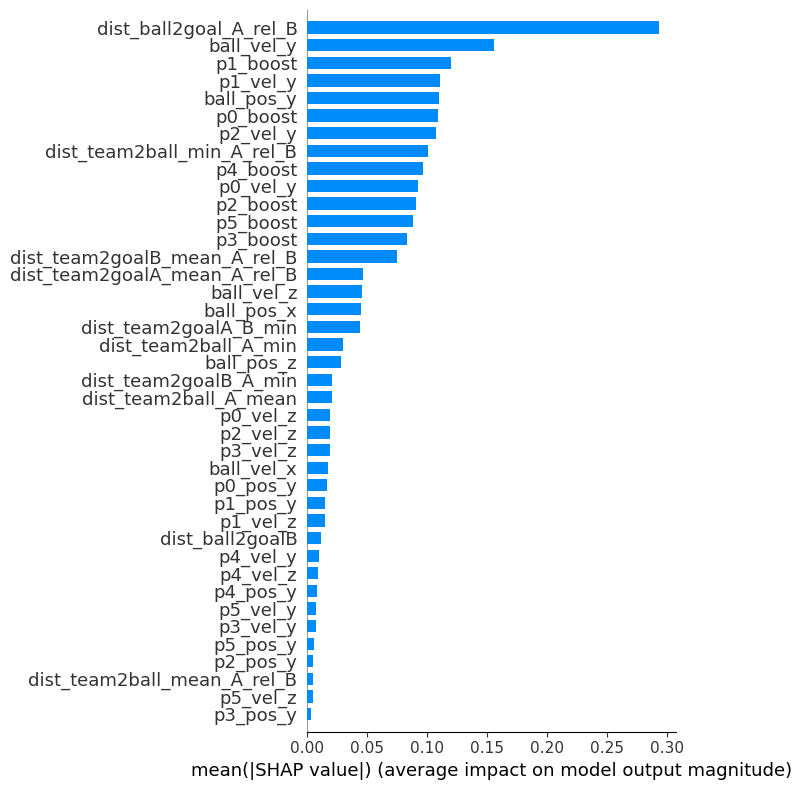

In [50]:
shap.summary_plot(shap_values[:, :-1], features, plot_type="bar", max_display=70, plot_size=(7, 8))

This gives an improved CV score again. Given that we engineered many features based on the position of the players, can we now safely drop the players' `y` positions?

In [51]:
features = [f for f in features if f not in list(filter(re.compile("p[0-5]_pos_y").match, features))]

In [52]:
shap_values = run_cv(train_df, features)

[0]	train-logloss:0.68519	valid-logloss:0.68522
[999]	train-logloss:0.18747	valid-logloss:0.19738
Fold 0 score: 0.19738
[0]	train-logloss:0.68520	valid-logloss:0.68521
[999]	train-logloss:0.18817	valid-logloss:0.19479
Fold 1 score: 0.19479
[0]	train-logloss:0.68520	valid-logloss:0.68519
[999]	train-logloss:0.18907	valid-logloss:0.19160
Fold 2 score: 0.19160
[0]	train-logloss:0.68521	valid-logloss:0.68519
[999]	train-logloss:0.18921	valid-logloss:0.19080
Fold 3 score: 0.19080
[0]	train-logloss:0.68521	valid-logloss:0.68520
[999]	train-logloss:0.18913	valid-logloss:0.19146
Fold 4 score: 0.19146
CV score: 0.19321


It sure looks that way.

Let's move on. As of yet, the model doesn't seem to use the information contained in the `y` velocity of the players. Do some aggregations for both teams help?

In [53]:
def yvel_team(df):
    df["yvel_A_max"] = df[[f"p{p}_vel_y" for p in range(3)]].max(axis=1)
    df["yvel_B_max"] = df[[f"p{p}_vel_y" for p in range(3, 6)]].max(axis=1)
    df["yvel_A_mean"] = df[[f"p{p}_vel_y" for p in range(3)]].mean(axis=1)
    return df

def compute_features(df):
    df = distance_ball_goal(df)
    df = distance_team_ball(df)
    df = distance_team_goal(df)
    df = yvel_team(df)
    return df

In [54]:
train_df = compute_features(train_df)
test_df = compute_features(test_df)

yvel_features = ["yvel_A_max", "yvel_B_max", "yvel_A_mean"]
features += yvel_features

The as_gpu_matrix method will be removed in a future cuDF release. Consider using `to_cupy` instead.


In [55]:
shap_values = run_cv(train_df, features)

[0]	train-logloss:0.68518	valid-logloss:0.68522
[999]	train-logloss:0.18756	valid-logloss:0.19735
Fold 0 score: 0.19735
[0]	train-logloss:0.68520	valid-logloss:0.68521
[999]	train-logloss:0.18823	valid-logloss:0.19466
Fold 1 score: 0.19466
[0]	train-logloss:0.68520	valid-logloss:0.68520
[999]	train-logloss:0.18912	valid-logloss:0.19169
Fold 2 score: 0.19169
[0]	train-logloss:0.68521	valid-logloss:0.68519
[999]	train-logloss:0.18918	valid-logloss:0.19081
Fold 3 score: 0.19081
[0]	train-logloss:0.68521	valid-logloss:0.68520
[999]	train-logloss:0.18909	valid-logloss:0.19140
Fold 4 score: 0.19140
CV score: 0.19318


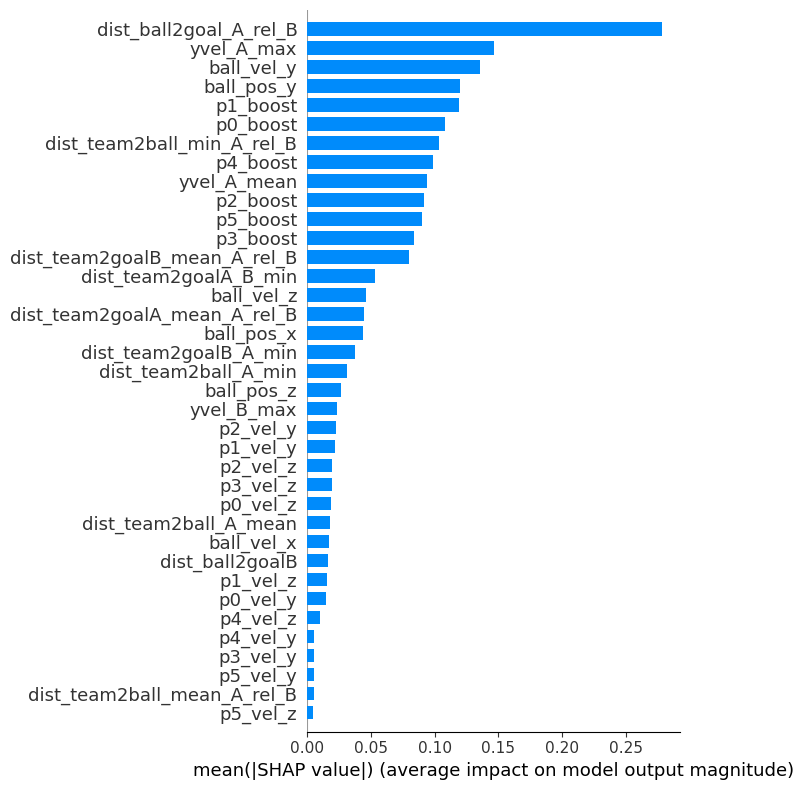

In [56]:
shap.summary_plot(shap_values[:, :-1], features, plot_type="bar", max_display=70, plot_size=(7, 8))

That's another tiny improvement. Let's try one last thing: The player's boost appears to be very important. What about corresponding aggregate features for both teams?

In [57]:
def boost_team(df):
    players_A = df[[f"p{p}_boost" for p in range(3)]].copy()
    df["boost_A_min"] = players_A.min(axis=1)
    df["boost_A_max"] = players_A.max(axis=1)
    df["boost_A_mean"] = players_A.mean(axis=1)
    players_B = df[[f"p{p}_boost" for p in range(3, 6)]].copy()
    df["boost_B_min"] = players_B.min(axis=1)
    df["boost_B_max"] = players_B.max(axis=1)
    df["boost_B_mean"] = players_B.mean(axis=1)
    
    return df

def compute_features(df):
    df = distance_ball_goal(df)
    df = distance_team_ball(df)
    df = distance_team_goal(df)
    df = yvel_team(df)
    df = boost_team(df)
    return df

In [58]:
train_df = compute_features(train_df)
test_df = compute_features(test_df)

boost_features = ["boost_A_min", "boost_A_max", "boost_A_mean", "boost_B_min", "boost_B_max", "boost_B_mean"]
features += boost_features

The as_gpu_matrix method will be removed in a future cuDF release. Consider using `to_cupy` instead.


In [59]:
shap_values = run_cv(train_df, features)

[0]	train-logloss:0.68518	valid-logloss:0.68522
[999]	train-logloss:0.18763	valid-logloss:0.19730
Fold 0 score: 0.19730
[0]	train-logloss:0.68520	valid-logloss:0.68521
[999]	train-logloss:0.18830	valid-logloss:0.19456
Fold 1 score: 0.19456
[0]	train-logloss:0.68520	valid-logloss:0.68519
[999]	train-logloss:0.18916	valid-logloss:0.19151
Fold 2 score: 0.19151
[0]	train-logloss:0.68521	valid-logloss:0.68519
[999]	train-logloss:0.18930	valid-logloss:0.19056
Fold 3 score: 0.19056
[0]	train-logloss:0.68520	valid-logloss:0.68520
[999]	train-logloss:0.18917	valid-logloss:0.19120
Fold 4 score: 0.19120
CV score: 0.19302


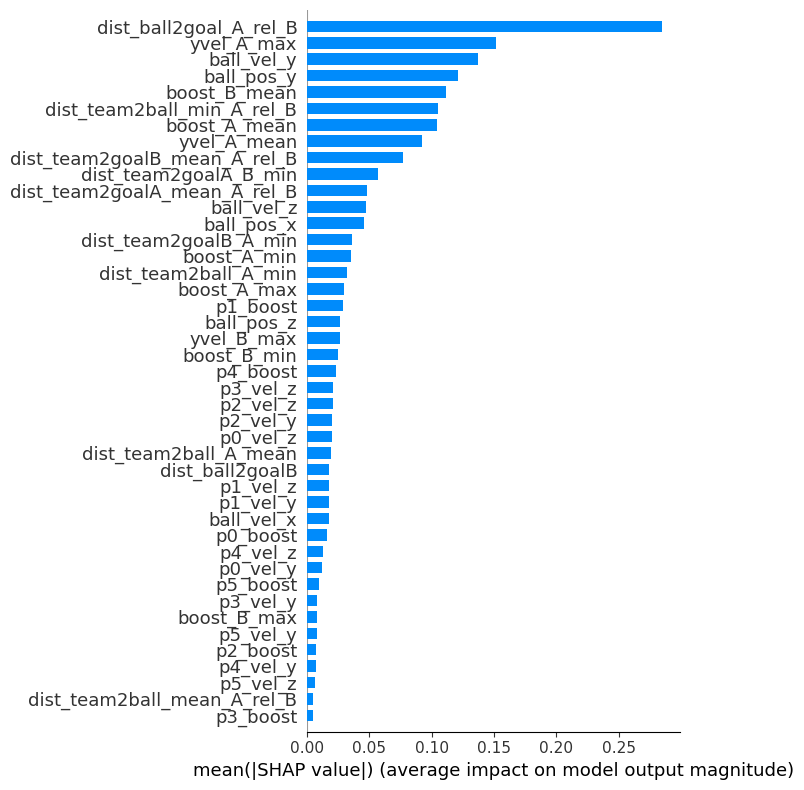

In [60]:
shap.summary_plot(shap_values[:, :-1], features, plot_type="bar", max_display=70, plot_size=(7, 8))

That's yet another improvement of the CV score. 

There are endless potential avenues for feature engineering left: we could add features related to missing players, try to leverage angles computed for the movement of the players and the ball in relation to each other and the goal, extrapolate the position of the ball based on its velocity vector, make more out of the boost timers (maybe link them to the position of the players), experiment with binning to see whether the high precision really is useful, etc. For the sake of brevity, though, we'll call it a day.

In the next and final post, we'll try to improve our model further with hyperparameter optimization.